# Wine Quality Prediction
## EDA

In [24]:
# First lets import the libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

Now lets read the data and check that everything worked.

In [25]:
df = pd.read_csv("winequality-red.csv")
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [26]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Check for missing values

In [27]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# EDA
First lets see how the different quality wine is distributed

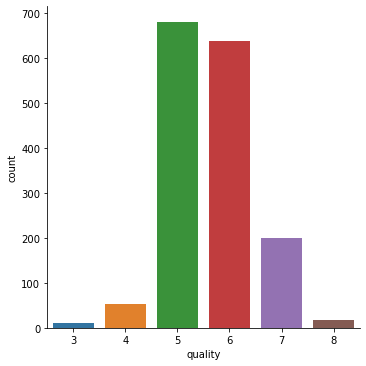

In [28]:
sns.catplot(x = 'quality', kind = 'count', data = df)

In [29]:
df.groupby('quality').size()

quality
3     10
4     53
5    681
6    638
7    199
8     18
dtype: int64

Here we are seeing a problem where the wines of quality 5 and 6 are very overrepresented and that will mess with our data analysis.\
We can't possible get an accurate model for predicting wines of quality 3 when we only have 10 samples. \
So instead lets bin the quality into 2 groups, good quality and bad quality.

In [30]:
df['quality'] = df['quality'].apply(lambda quality: 1 if quality >= 6 else 0)

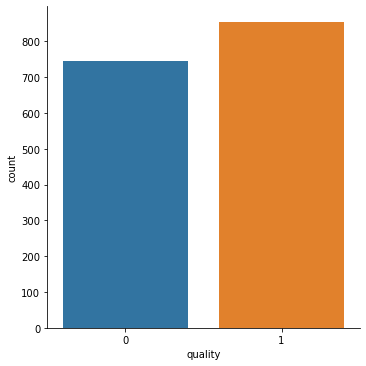

In [31]:
sns.catplot(x = 'quality', kind = 'count', data = df)

Now when our target variable is looking good we can start looking at our predictor variables.

<AxesSubplot:>

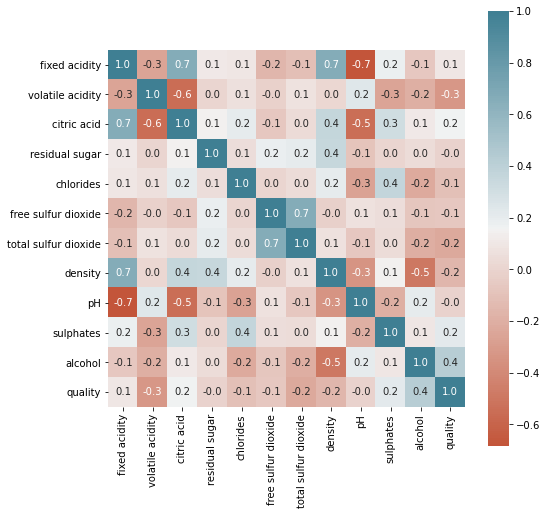

In [32]:
corr = df.corr()
plt.figure(figsize = (8,8))
sns.heatmap(corr, 
            cbar = True,
            square = True,
            fmt = '.1f',
            annot = True,
            cmap = sns.diverging_palette(20, 220, n = 200))

Looking at quality row of the correlation plot we can see that alcohol and volatile acidity seems to be correlated the most with quality. \
Lets plot them against quality.

Text(0.5, 1.0, 'Alcohol vs Quality')

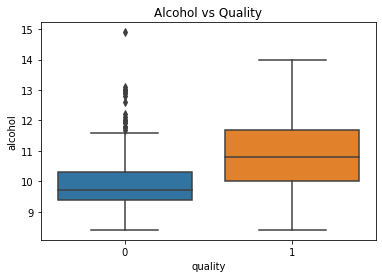

In [33]:
sns.boxplot(x = 'quality', y = 'alcohol', data = df).set_title("Alcohol vs Quality")

Text(0.5, 1.0, 'Volatile Acidity vs Quality')

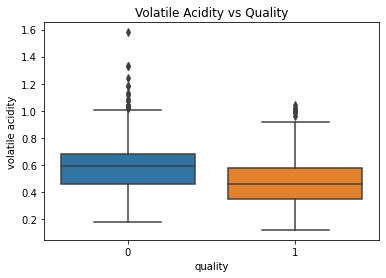

In [34]:
sns.boxplot(x = 'quality', y = 'volatile acidity', data = df).set_title("Volatile Acidity vs Quality")

Here I am tempted to remove the outliers from the alcohol and volatile acidity since there seem to be quite a few.\
Also the correlation between the target variable and the predictor variables found earlier was quite small and removing the outliers should increase the correlation in this case. \
So, lets remove them. \
First we split by  group and then we remove outliers from each group.

In [35]:
df1, df2 = [x for _, x in df.groupby('quality')]

While there are packages that can calculate the outlier cutoff for us lets instead do it by hand.\
Using a boxplot definition of outliers we make the cutoff Q1/Q3 -/+ 1.5*IQR.

In [36]:
df1 = df1.sort_values('alcohol')
median = int(len(df1.index) / 2)
Q3 = df1['alcohol'][median:].median()
Q1 = df1['alcohol'][:median].median()
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
lower_limit = Q1 - 1.5*IQR
print(upper_limit, lower_limit)

11.650000000000002 8.05


In [37]:
df1 = df1[df1['alcohol'] < upper_limit]
df1 = df1[df1['alcohol'] > lower_limit]

In [38]:
df1 = df1.sort_values('volatile acidity')
median = int(len(df1.index) / 2)
Q3 = df1['volatile acidity'][median:].median()
Q1 = df1['volatile acidity'][:median].median()
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
lower_limit = Q1 - 1.5*IQR
print(upper_limit, lower_limit)
df1 = df1[df1['volatile acidity'] < upper_limit]
df1 = df1[df1['volatile acidity'] > lower_limit]
df1.describe()

1.0162500000000003 0.12624999999999992


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.0
mean,8.175955,0.577044,0.241528,2.522914,0.093849,16.763791,55.349364,0.997161,3.303946,0.622051,9.837129,0.0
std,1.519109,0.157105,0.181781,1.378204,0.056651,10.957784,36.701425,0.001512,0.148175,0.178878,0.606904,0.0
min,5.200000,0.180000,0.000000,1.200000,0.039000,3.000000,6.000000,0.993360,2.740000,0.330000,8.400000,0.0
25%,7.100000,0.460000,0.080000,1.900000,0.074000,8.000000,25.000000,0.996200,3.200000,0.525000,9.400000,0.0
50%,7.800000,0.590000,0.230000,2.200000,0.081000,15.000000,47.000000,0.997000,3.300000,0.580000,9.600000,0.0
75%,8.900000,0.670000,0.360000,2.600000,0.094000,23.000000,78.500000,0.997935,3.390000,0.660000,10.200000,0.0
max,15.600000,1.005000,1.000000,15.500000,0.611000,68.000000,155.000000,1.003150,3.720000,2.000000,11.600000,0.0


In [39]:
df2 = df2.sort_values('alcohol')
median = int(len(df2.index) / 2)
Q3 = df2['alcohol'][median:].median()
Q1 = df2['alcohol'][:median].median()
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
lower_limit = Q1 - 1.5*IQR
print(upper_limit, lower_limit)
df2 = df2[df2['alcohol'] < upper_limit]
df2 = df2[df2['alcohol'] > lower_limit]

df2 = df2.sort_values('volatile acidity')
median = int(len(df2.index) / 2)
Q3 = df2['volatile acidity'][median:].median()
Q1 = df2['volatile acidity'][:median].median()
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
lower_limit = Q1 - 1.5*IQR
print(upper_limit, lower_limit)
df2 = df2[df2['volatile acidity'] < upper_limit]
df2 = df2[df2['volatile acidity'] > lower_limit]
df2.describe()

14.249999999999998 7.450000000000001
0.9249999999999999 0.0050000000000000044


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,848.000000,848.000000,848.00000,848.00000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.0
mean,8.480778,0.469794,0.30079,2.53862,0.082791,15.294811,39.290094,0.996473,3.310024,0.693950,10.859021,1.0
std,1.864019,0.155368,0.19932,1.43010,0.037361,10.058641,27.248055,0.002069,0.154032,0.155426,1.105340,0.0
min,4.700000,0.120000,0.00000,0.90000,0.012000,1.000000,6.000000,0.990070,2.860000,0.390000,8.400000,1.0
25%,7.100000,0.350000,0.12000,1.90000,0.067000,7.000000,20.000000,0.995197,3.210000,0.590000,10.000000,1.0
50%,8.000000,0.460000,0.31000,2.20000,0.077000,13.000000,33.000000,0.996400,3.310000,0.660000,10.800000,1.0
75%,9.700000,0.580000,0.46000,2.60000,0.088000,21.000000,50.000000,0.997692,3.400000,0.770000,11.700000,1.0
max,15.600000,0.915000,0.78000,15.40000,0.415000,72.000000,289.000000,1.003690,4.010000,1.950000,14.000000,1.0


In [40]:
 df_new = pd.concat([df1,df2])

 If we look at our boxplots now we should see thatmost outliers are gone.

Text(0.5, 1.0, 'Alcohol vs Quality')

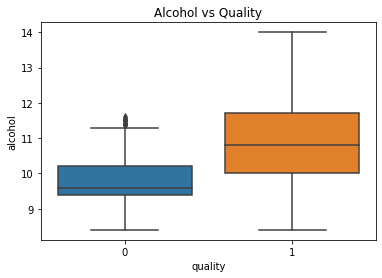

In [41]:
sns.boxplot(x = 'quality', y = 'alcohol', data = df_new).set_title("Alcohol vs Quality")

Text(0.5, 1.0, 'Volatile Acidity vs Quality')

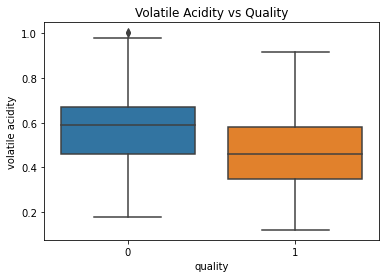

In [42]:
sns.boxplot(x = 'quality', y = 'volatile acidity', data = df_new).set_title("Volatile Acidity vs Quality")

Looks good.

In [43]:
print("Old length of data frame was ", len(df.index),'\n',
      "New length is ", len(df_new.index))

Old length of data frame was  1599 
 New length is  1555


# Model Building
Split data into a 20% test set and 80% training set.\
Need to set a seed to get reproducible.

In [44]:
X = df_new.drop('quality', axis = 1)
y = df_new['quality']
random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [45]:
print(X.shape, X_train.shape)

(1555, 11) (1244, 11)


## Random Forest
First lets try a Random Forest model. \
We will do this using a default 5-fold cross-validation for tuning the hyperparameters and then evaluating using R^2 score.

In [50]:
random.seed(7)
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf = RandomizedSearchCV(estimator = RandomForestClassifier(),
                param_distributions = param_grid,
                refit = True,
                verbose = 3,
                n_jobs = -1,
                n_iter = 20)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.8456591639871383

A R^2 score of 0.84 means that our model can explain 84% of the variation in the data.
### Feature Importance

Text(0, 0.5, 'Feature Names')

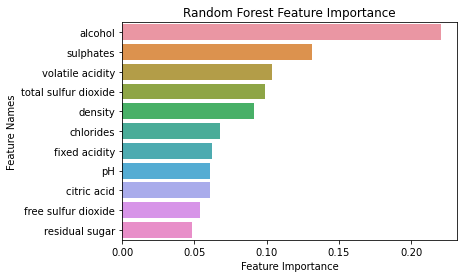

In [76]:
data = {'feature_names':X_train.columns,
       'feature_importance': rf.best_estimator_.feature_importances_}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names']).set_title("Random Forest Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")

As expected, alcohol was the most important feature for predicting the quality. However, sulphates was the second most important feature and not volatile acidity.

## XGBoost
Now lets try xgboost \
First we have to convert our dataframes into Dmatrices

In [51]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

Now lets set our hyperparameters

In [52]:
param_grid = {
    'max_depth': 8,
    'eta': 0.15,
    'objective': 'multi:softmax',
    'num_class': 2
}
epochs = 100

In [53]:
xgb_model = xgb.train(params, train, epochs)

[10:52:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
pred = xgb_model.predict(test)

In [55]:
accuracy_score(y_test, pred)

0.8327974276527331

Score of 0.83 means that our model can explain 83% of the variance of the data.
### Feature Importance
Now we plot the feature importance. \
XGBoost has function for this but it doesn't plot the GINI which is what we used for the RandomForest model.  
So we will make the plot ourselves.

Text(0, 0.5, 'Feature Names')

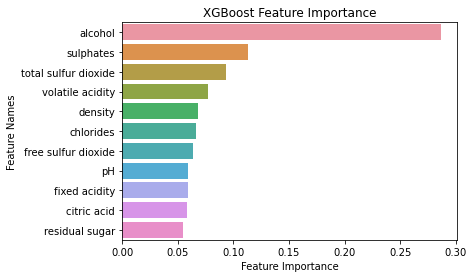

In [99]:
xfi_df = pd.DataFrame(xgb_model.get_score(importance_type='gain'), index = [0]).transpose()
xfi_df.sort_values(by = 0, ascending = False, inplace = True)
xfi_df[0] = xfi_df[0].div(xfi_df[0].sum())
sns.barplot(y = xfi_df.index, x = xfi_df[0]).set_title("XGBoost Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")

Comparing the 2 models we can see that RandomForest just barely beats Random Forest in R^2 score. \
We also see that both models have very similar feature importances which is to be expected since both models are tree based.